# TSMixer: Tuning

In [1]:
from src.silence import silence

silence()

import ast
import os
from itertools import product

import numpy as np
import pandas as pd
import torch
from darts.models import TSMixerModel
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from tqdm import tqdm

from config import METRIC, METRIC_KWARGS, ROOT
from src.tuning import compute_validation_score, exclude_covid_weights, train_validation_split
from src.realtime_utils import load_realtime_training_data


### Configuration

In [2]:
NAME = "tsmixer"
OUT_CSV = ROOT / "results" / "tuning" / "gridsearch_tsmixer_are.csv"
RANDOM_SEEDS = [1, 2, 3]

In [3]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {"datetime_attribute": {"future": ["month", "weekofyear"]}}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    pl_trainer_kwargs={
        "enable_progress_bar": False,
        "enable_model_summary": False,
        "accelerator": "cpu",
        "logger": False,
        # "callbacks" : [RichProgressBar(leave=True)],
    },
)

OPTIMIZER_DICT = {"Adam": torch.optim.Adam, "AdamW": torch.optim.AdamW, "SGD": torch.optim.SGD}

In [4]:
sweep_configuration = {
    "name": f"sari-{NAME}",
    "method": "grid",
    "metric": {"goal": "minimize", "name": "WIS"},
    "parameters": {
        "use_static_covariates": {"values": [False]},
        "use_covariates": {"values": [True, False]},
        "use_encoders": {"values": [True]},
        "sample_weight": {"values": ["linear"]},
        "input_chunk_length": {"values": [8]},
        "hidden_size": {"values": [32, 64]},
        "ff_size": {"values": [32, 64]},
        "num_blocks": {"values": [4, 6]},
        "dropout": {"values": [0.2]},  # 0.05, 0.1, 0.2, 0.3, 0.5
        "norm_type": {"values": ["TimeBatchNorm2d"]},  # 'LayerNorm',
        "batch_size": {"values": [32]},
        "n_epochs": {"values": [500, 1000]},
        "normalize_before": {"values": [False]},
        "activation": {"values": ["ReLU"]},  # "ReLU", "GELU", "LeakyReLU", "ELU"
        "optimizer": {"values": ["AdamW"]},  # SGD, "Adam",
        "optimizer_kwargs": {
            "parameters": {"lr": {"values": [0.0005, 0.001, 0.005]}, "weight_decay": {"values": [0, 0.001, 0.0001]}}
        },
    },
}

In [5]:
def space_from_sweep(sweep_cfg: dict) -> dict:
    space = {}
    for k, v in sweep_cfg["parameters"].items():
        if k == "optimizer_kwargs":  # special case: flatten
            sub = v["parameters"]
            space["optimizer_kwargs.lr"] = list(sub["lr"]["values"])
            space["optimizer_kwargs.weight_decay"] = list(sub["weight_decay"]["values"])
        else:
            space[k] = list(v["values"])
    return space

In [6]:
def iter_configs(space: dict):
    keys = list(space.keys())
    for vals in product(*(space[k] for k in keys)):
        yield dict(zip(keys, vals))

In [7]:
def eval_config(cfg: dict) -> dict:
    optimizer = OPTIMIZER_DICT[cfg["optimizer"]]
    use_covariates = cfg["use_covariates"]
    sample_weight = cfg["sample_weight"]

    scores = {}
    for seed in RANDOM_SEEDS:
        model = TSMixerModel(
            input_chunk_length=cfg["input_chunk_length"],
            hidden_size=cfg["hidden_size"],
            ff_size=cfg["ff_size"],
            num_blocks=cfg["num_blocks"],
            dropout=cfg["dropout"],
            norm_type=cfg["norm_type"],
            batch_size=cfg["batch_size"],
            n_epochs=cfg["n_epochs"],
            normalize_before=cfg["normalize_before"],
            activation=cfg["activation"],
            optimizer_cls=optimizer,
            optimizer_kwargs={
                "lr": cfg["optimizer_kwargs.lr"],
                "weight_decay": cfg["optimizer_kwargs.weight_decay"],
            },
            use_static_covariates=cfg["use_static_covariates"],
            add_encoders=ENCODERS if cfg["use_encoders"] else None,
            **SHARED_ARGS,
            random_state=seed,
        )

        score = compute_validation_score(
            model,
            targets_train,
            targets_validation,
            covariates if use_covariates else None,
            HORIZON,
            NUM_SAMPLES,
            METRIC,
            METRIC_KWARGS,
            sample_weight=custom_weights if sample_weight == "no-covid" else sample_weight,
        )
        scores[f"WIS_{seed}"] = score

    per_seed = list(scores.values())
    scores["WIS"] = np.mean(per_seed)
    scores["WIS_std"] = np.std(per_seed)

    return {
        **scores,
        **{f"cfg.{k}": v for k, v in cfg.items()},
    }

In [8]:
def run_gridsearch(resume=False):
    space = space_from_sweep(sweep_configuration)
    configs = list(iter_configs(space))

    param_cols = list(space.keys())
    score_cols = ["WIS_1", "WIS_2", "WIS_3", "WIS", "WIS_std"]
    header = param_cols + score_cols + ["error_flag", "error_msg"]

    if resume and os.path.exists(OUT_CSV):
        gs = pd.read_csv(OUT_CSV)

        # convert string representations into dicts and tuples
        gs["lags_past_covariates"] = gs["lags_past_covariates"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        gs["lags_future_covariates"] = gs["lags_future_covariates"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

        gs = gs.drop(columns=["WIS", "error_flag", "error_msg"]).to_dict("records")
        configs = [c for c in configs if c not in gs]

    if not os.path.exists(OUT_CSV):
        pd.DataFrame(columns=header).to_csv(OUT_CSV, index=False)

    total = len(configs)
    pbar = tqdm(configs, total=total, desc="Grid search", unit="trial")
    for cfg in pbar:
        row = {k: cfg.get(k) for k in param_cols}
        try:
            res = eval_config(cfg)
            for sc in score_cols:
                row[sc] = res.get(sc, np.nan)
            row.update({"error_flag": False, "error_msg": ""})
            wis = row["WIS"]
        except Exception as e:
            for sc in score_cols:
                row[sc] = np.nan
            row.update({"error_flag": True, "error_msg": str(e)})
            wis = np.nan

        pd.DataFrame([row], columns=header).to_csv(OUT_CSV, mode="a", header=False, index=False)

        pbar.set_postfix(
            {
                "WIS": f"{wis:.4f}" if isinstance(wis, (float, np.floating)) and not np.isnan(wis) else "nan",
            }
        )

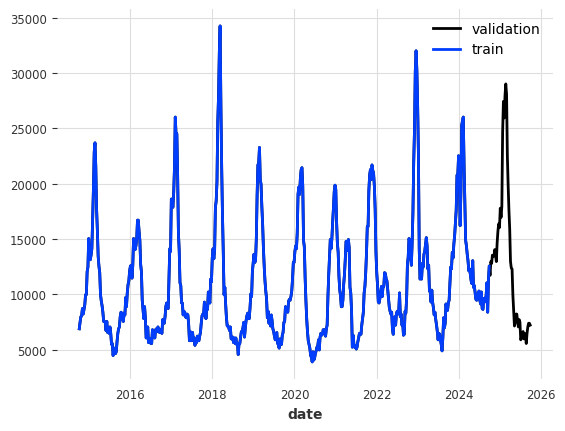

In [9]:
targets, covariates = load_realtime_training_data()

targets_train, targets_validation = train_validation_split(targets, 2024)

targets_validation["icosari-sari-DE"].plot(label="validation")
targets_train["icosari-sari-DE"].plot(label="train")

custom_weights = exclude_covid_weights(targets)

In [ ]:
run_gridsearch()

# ARE

In [9]:
covariates, targets = load_realtime_training_data()
targets = targets.slice_intersect(covariates)
targets_train, targets_validation = train_validation_split(targets, 2024)

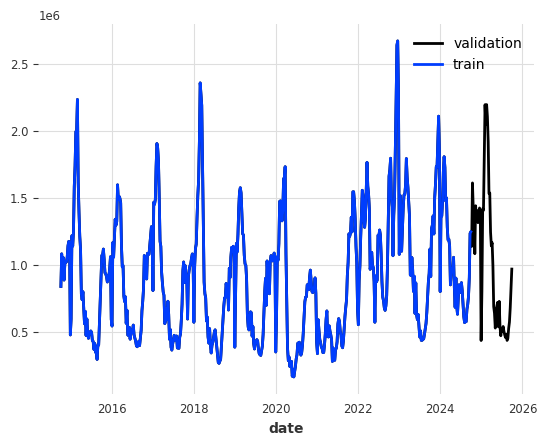

In [10]:
targets_validation['agi-are-DE'].plot(label='validation')
targets_train['agi-are-DE'].plot(label='train')

custom_weights = exclude_covid_weights(targets)

In [ ]:
run_gridsearch()

Grid search:  14%|█▎        | 39/288 [7:14:30<43:38:39, 631.00s/trial, WIS=63244.4943]